In [ ]:
%whos

In [1]:
key = pd.read_csv('../data/key.csv')
train = pd.read_csv('../data/train.csv')
weather = pd.read_csv('../data/weather.csv')
test = pd.read_csv('../data/test.csv')

In [2]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [3]:
train['log_units'] = np.log(train['units'] + 1)
train.tail()

,date,store_nbr,item_nbr,units,log_units
4617595,2014-10-31,45,107,0,0.0
4617596,2014-10-31,45,108,0,0.0
4617597,2014-10-31,45,109,0,0.0
4617598,2014-10-31,45,110,0,0.0
4617599,2014-10-31,45,111,0,0.0


In [25]:
train_new = train[:2255853] # 2013년 3월 31일까지의 train data

In [4]:
weather_train = weather[:8968] # 2013년 3월 31일까지의 weather data

### weather 관련 functions

In [5]:
def get_weather_train(df, station_nbr) : # staion_nbr에 따라서 weather train dataframe을 만드는 함수
    new_df = df[df['station_nbr'] == station_nbr]
    new_df.reset_index(drop = True, inplace = True)
    return new_df    

In [6]:
def set_tmax(df) : # tmax의 missing value를 처리하는 함수
    for num in range(len(df)) :  # tmax의 missing value 처리,,, 이틀 전날의 0.2배 + 하루 전날의 0.8배
        if df.at[num, 'tmax'] == 'M' :
            df.set_value(num, 'tmax', int(0.2 * int(df.at[num - 2, 'tmax']) + 0.8 * int(df.at[num - 1, 'tmax'])))
        
        else :
            df.at[num, 'tmax'] = int(df.at[num, 'tmax'])

In [7]:
def set_tmin(df) : # tmin의 missing value를 처리하는 함수
    for num in range(len(df)) :  # tmax의 missing value 처리,,, 이틀 전날의 0.2배 + 하루 전날의 0.8배
        if df.at[num, 'tmin'] == 'M' :
            df.set_value(num, 'tmin', int(0.2 * int(df.at[num - 2, 'tmin']) + 0.8 * int(df.at[num - 1, 'tmin'])))
            
        else :
            df.at[num,'tmin'] = int(df.at[num, 'tmin'])

In [8]:
def set_tavg(df) : # tavg의 값을 처리하는 함수
    for num in range(len(df)) :
        if df.at[num, 'tavg'] == 'M' :
            df.set_value(num, 'tavg', int((df.at[num, 'tmax'] + df.at[num, 'tmin']) / 2)) # (tmax + tmin) / 2
            
        else :
            df.at[num, 'tavg'] = int(df.at[num, 'tavg'])   

In [9]:
def set_depart(df) : # how can I get depart value..wtf
    if df.at[0, 'depart'] == 'M' :
        print("Cannot get depart value") # depart값을 구할 수 없는 경우
            
    else :
        depart_base = int(df.at[0, 'tavg']) - int(df.at[0, 'depart']) # 각 weather station을 보면 tavg - depart값이 일정하다.. 개이득..
        for num in range(1, len(df)) :
            df.set_value(num, 'depart', int((df.at[num, 'tavg'] - depart_base)))

In [10]:
def set_dewpoint(df) : 
    for num in range(len(df)) :
        if df.at[num, 'dewpoint'] == 'M' :
            df.set_value(num, 'dewpoint', np.nan)

In [11]:
def set_wetbulb(df) : # 습구온도는 불포화공기에서는 건구온도보다 낮고 노점(이슬점, dewpoint)보다 높지만, 포화공기에서 3자는 일치한다.
    for num in range(len(df)) :
        if df.at[num, 'wetbulb'] == 'M' :
            df.set_value(num, 'wetbulb', np.nan)

In [12]:
def set_heat_cool(df) : # heat, cool의 missing value 처리
    for num in range(len(df)) :
        if df.at[num, 'heat'] == 'M' or df.at[num, 'cool'] == 'M' :
            
            if df.at[num, 'tavg'] == 65 : # tavg == 65 이면 heat, cool 모두 0
                df.set_value(num, 'heat', 0)
                df.set_value(num, 'cool', 0)
            
            elif df.at[num, 'tavg'] > 65 : #tavg > 65 이면 heat = 0, cool = tavg - 65
                df.set_value(num, 'heat', 0)
                df.set_value(num, 'cool', df.at[num, 'tavg'] - 65)
            
            else : #tavg < 65 이면 heat = 65 - tavg, cool = 0
                df.set_value(num, 'heat', 65 - df.at[num, 'tavg'])
                df.set_value(num, 'cool', 0)

In [13]:
def merge_heat_cool(df) :
    df['heat/cool'] = ""
    
    for num in range(len(df)) :
        df.set_value(num, "heat/cool", int(df.at[num, "cool"]) - int(df.at[num, "heat"]))

In [14]:
def set_snowfall_preciptotal(df) : #codesum에 RA가 있는데 preciptotal이 T인경우도있다...
    for num in range(len(df)) :
        if ('T' in df.at[num, 'snowfall']) or ('M' in df.at[num, 'snowfall']) : # snowfall이 trace or M이면 0으로 setting
            df.set_value(num, 'snowfall', 0.0)
        
        if ('T' in df.at[num, 'preciptotal']) or ('M' in df.at[num, 'preciptotal']) : # preciptotal이 trace or M이면 0으로 setting
            df.set_value(num, 'preciptotal', 0.0)

In [15]:
def set_stnpressure(df) :
    for num in range(len(df)) :
        if df.at[num, 'stnpressure'] == 'M' :
            df.set_value(num, 'stnpressure', np.nan)

In [16]:
def set_sealevel(df) :
    for num in range(len(df)) :
        if df.at[num, 'sealevel'] == 'M' :
            df.set_value(num, 'sealevel', np.nan)

In [17]:
def set_resultspeed(df) : # 바람관련 column 3개는 어떤 연관관계가 있지않을까..
#     The fastest 2-minute (average) wind speed, in Miles Per Hour.
    for num in range(len(df)) :
        if df.at[num, 'resultspeed'] == 'M' :
            df.set_value(num, 'resultspeed', np.nan)

In [18]:
def set_resultdir(df) :
#     resultdir : The direction the fastest 2-minute wind was blowing FROM in tens of degrees
#     27 would be 270 degrees = wind was blowing from the west to the east
#     (36 = North, 09 = East, 18 = South, 27 = West)
    for num in range(len(df)) :
        if df.at[num, 'resultdir'] == 'M' :
            df.set_value(num, 'resultdir', np.nan)

In [19]:
def set_avgspeed(df) :
#     The average wind speed for the day, in Miles Per Hour
    for num in range(len(df)) :
        if df.at[num, 'avgspeed'] == 'M' :
            df.set_value(num, 'avgspeed', np.nan)

### train 관련 functions

In [20]:
def get_train_train(df, store_nbr) : # store_nbr에 따라 train data를 나눠주는 함수
    new_df = df[df['store_nbr'] == store_nbr]
    new_df.reset_index(drop = True, inplace = True)
    return new_df

### weather와 train data를 합쳐주는 함수
- train data 중 log_units != 0 인 item들만 합쳐줌.. (log_units != 0 이면 units != 0)

In [21]:
def merge_weather_train(weather, train) :
    train_pivot = train.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
    train_pivot = train_pivot.loc[:, (train_pivot != 0).any(axis = 0)] # log_units이 모두 0인 item_nbr(column)을 삭제..
    train_pivot.loc['2012-12-25'] = 0 # 2012-12-25의 data를 0으로 추가... 원래 없었던 data이므로 0으로 설정함
    
    list_item_nbr = train_pivot.columns # units 전체가 0이 아닌 item_nbr들을 list형태로 받음
#     length = len(train_pivot.columns) # units전체가 0이 아닌 item_nbr이 총 몇개 있는지..
        
    train_pivot.index.name = "date"
    train_pivot.reset_index(inplace = True)
    train_pivot.sort_values(by = 'date', inplace = True)
    train_pivot.reset_index(drop = True, inplace = True)
    
    for num in list_item_nbr :
        weather[num] = train_pivot[num]
    
    return weather

In [22]:
def get_item_nbr(df) : # 모든 units이 0이 아닌 item_nbr을 구하는 함수, list형태로 return
    tmp = df.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
    tmp = tmp.loc[:, (tmp != 0).any(axis = 0)]
    tmp.loc['2012-12-25'] = 0 # 2012-12-25가 빠져있음 train data에서.. 그래서 log_units = 0으로 넣어줌.
    
    tmp.reset_index(inplace = True)
    tmp.sort_values(by = 'date', inplace = True)
    tmp.drop(['date'], axis = 1, inplace = True)
    
    result = list(tmp.columns)
    
    return result

In [23]:
#station_nbr로 weather_train을 나눠줌
# 박두진 강사님이 이 부분을 줄일 수 있는 방법을 찾아봐주신다 하였음..일단은 그냥 쓰자!

weather_train_1 = get_weather_train(weather_train, 1)
weather_train_2 = get_weather_train(weather_train, 2)
weather_train_3 = get_weather_train(weather_train, 3)
weather_train_4 = get_weather_train(weather_train, 4)
weather_train_5 = get_weather_train(weather_train, 5) # missing value가 많아서 일단은..
weather_train_6 = get_weather_train(weather_train, 6)
weather_train_7 = get_weather_train(weather_train, 7)
weather_train_8 = get_weather_train(weather_train, 8)
weather_train_9 = get_weather_train(weather_train, 9)
weather_train_10 = get_weather_train(weather_train, 10)
weather_train_11 = get_weather_train(weather_train, 11)
weather_train_12 = get_weather_train(weather_train, 12)
weather_train_13 = get_weather_train(weather_train, 13)
weather_train_14 = get_weather_train(weather_train, 14)
weather_train_15 = get_weather_train(weather_train, 15)
weather_train_16 = get_weather_train(weather_train, 16)
weather_train_17 = get_weather_train(weather_train, 17)
weather_train_18 = get_weather_train(weather_train, 18)
weather_train_19 = get_weather_train(weather_train, 19)
weather_train_20 = get_weather_train(weather_train, 20)

In [26]:
train_new_1 = get_train_train(train_new, 1)
train_new_2 = get_train_train(train_new, 2)
train_new_3 = get_train_train(train_new, 3)
train_new_4 = get_train_train(train_new, 4)
train_new_5 = get_train_train(train_new, 5)
train_new_6 = get_train_train(train_new, 6)
train_new_7 = get_train_train(train_new, 7)
train_new_8 = get_train_train(train_new, 8)
train_new_9 = get_train_train(train_new, 9)
train_new_10 = get_train_train(train_new, 10)
train_new_11 = get_train_train(train_new, 11)
train_new_12 = get_train_train(train_new, 12)
train_new_13 = get_train_train(train_new, 13)
train_new_14 = get_train_train(train_new, 14)
train_new_15 = get_train_train(train_new, 15)
train_new_16 = get_train_train(train_new, 16)
train_new_17 = get_train_train(train_new, 17)
train_new_18 = get_train_train(train_new, 18)
train_new_19 = get_train_train(train_new, 19)
train_new_20 = get_train_train(train_new, 20)
train_new_21 = get_train_train(train_new, 21)
train_new_22 = get_train_train(train_new, 22)
train_new_23 = get_train_train(train_new, 23)
train_new_24 = get_train_train(train_new, 24)
train_new_25 = get_train_train(train_new, 25)
train_new_26 = get_train_train(train_new, 26)
train_new_27 = get_train_train(train_new, 27)
train_new_28 = get_train_train(train_new, 28)
train_new_29 = get_train_train(train_new, 29)
train_new_30 = get_train_train(train_new, 30)
train_new_31 = get_train_train(train_new, 31)
train_new_32 = get_train_train(train_new, 32)
train_new_33 = get_train_train(train_new, 33)
train_new_34 = get_train_train(train_new, 34)
train_new_35 = get_train_train(train_new, 35)
train_new_36 = get_train_train(train_new, 36)
train_new_37 = get_train_train(train_new, 37)
train_new_38 = get_train_train(train_new, 38)
train_new_39 = get_train_train(train_new, 39)
train_new_40 = get_train_train(train_new, 40)
train_new_41 = get_train_train(train_new, 41)
train_new_42 = get_train_train(train_new, 42)
train_new_43 = get_train_train(train_new, 43)
train_new_44 = get_train_train(train_new, 44)
train_new_45 = get_train_train(train_new, 45)

## 각 dataframe별로 뒤에 붙는 숫자에 주의해야함
- station_nbr 기준인지 store_nbr 기준인지...

### station_nbr별 특징
- no depart value : 1, 7, 8, 9, 10, 12, 13, 16, 17, 20
    - drop??

### station_nbr == 1
- store_nbr == 1
- no depart value

In [27]:
set_tmax(weather_train_1)
set_tmin(weather_train_1)
set_tavg(weather_train_1)
set_heat_cool(weather_train_1)
merge_heat_cool(weather_train_1)
set_depart(weather_train_1)
set_snowfall_preciptotal(weather_train_1)
set_dewpoint(weather_train_1)
set_wetbulb(weather_train_1)
set_stnpressure(weather_train_1)
set_sealevel(weather_train_1)
set_resultspeed(weather_train_1)
set_resultdir(weather_train_1)
set_avgspeed(weather_train_1)

# merged_1 = merge_weather_train(weather_train_1, train_new_1)
item_nbr_list_1 = get_item_nbr(train_new_1)

Cannot get depart value


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[9, 28, 40, 51, 89, 93, 99]

In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_1 :
    plt.subplot(len(item_nbr_list_1), 1, plotcount)
    plt.scatter(x = merged_1['tmax'], y = merged_1[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount += 1

In [ ]:
sns.pairplot(merged_1, x_vars = ['tmax', 'tmin', 'tavg'], y_vars = item_nbr_list_1)

In [27]:
weather_train_1_test = weather_train_1.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

train_new_1_pivot = train_new_1.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# train_new_1_pivot.loc[len(train_new_1)] = 0
# train_new_1_pivot.reset_index(drop = True, inplace = True)

# test = train_new_1.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
train_new_1_pivot = pd.DataFrame(np.insert(train_new_1_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_1 :
    dfX = sm.add_constant(weather_train_1_test)
    dfy = pd.DataFrame(np.asarray(train_new_1_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 9   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.514
Date:                Wed, 28 Feb 2018   Prob (F-statistic):              0.123
Time:                        09:35:26   Log-Likelihood:                -522.61
No. Observations:                 449   AIC:                             1069.
Df Residuals:                     437   BIC:                             1119.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0047      0.004     -1.239      

In [ ]:
# linear regression에서는 array형태 data type이 필요하다.. np.asarray
# NaN값이 있으면 안되나벼..

weather_train_1_test_array = np.asarray(weather_train_1_test)

for num in item_nbr_list_1 :

    model2 = LinearRegression().fit(weather_train_1_test_array, np.asarray(train_new_1_pivot[num]))

    # model2.coef_
    # model2.intercept_

    predictions = model2.predict(np.asarray(weather_train_1_test_array))

    plt.scatter(train_new_1_pivot[num], predictions)
    # plt.xlabel(u"실제 집값")
    # plt.ylabel(u"집값 예측치")
    plt.show()

###  station_nbr == 2
- store_nbr == 16

In [28]:
set_tmax(weather_train_2)
set_tmin(weather_train_2)
set_tavg(weather_train_2)
set_heat_cool(weather_train_2)
merge_heat_cool(weather_train_2)
set_depart(weather_train_2)
set_snowfall_preciptotal(weather_train_2)
set_dewpoint(weather_train_2)
set_wetbulb(weather_train_2)
set_stnpressure(weather_train_2)
set_sealevel(weather_train_2)
set_resultspeed(weather_train_2)
set_resultdir(weather_train_2)
set_avgspeed(weather_train_2)

# merged_2 = merge_weather_train(weather_train_2, train_new_16)
item_nbr_list_2 = get_item_nbr(train_new_16)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


NameError: name 'merged_2' is not defined

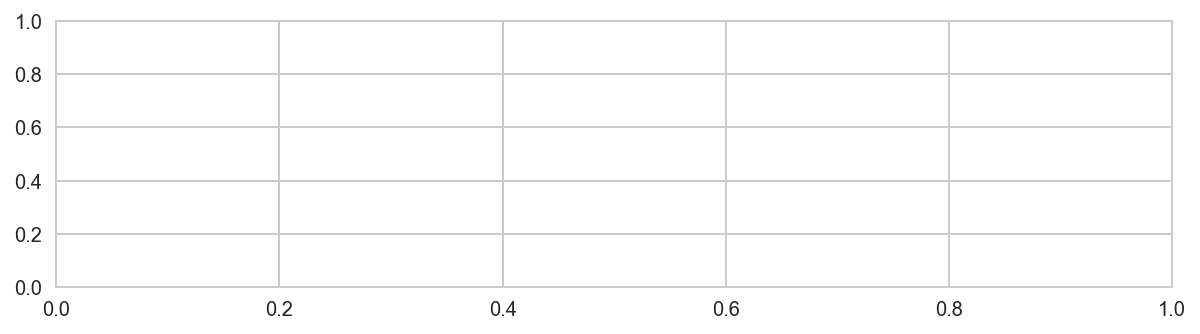

In [29]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_2 :
    plt.subplot(len(item_nbr_list_2), 1, plotcount)
    plt.scatter(x = merged_2['tmax'], y = merged_2[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount += 1

In [29]:
weather_train_2_test = weather_train_2.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

train_new_16_pivot = train_new_16.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# train_new_16_pivot.loc[len(train_new_16)] = 0
# train_new_16_pivot.reset_index(drop = True, inplace = True)

train_new_16_pivot = pd.DataFrame(np.insert(train_new_16_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_2 :
    dfX = sm.add_constant(weather_train_1_test)
    dfy = pd.DataFrame(np.asarray(train_new_16_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:         item_nbr == 16   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     2.376
Date:                Wed, 28 Feb 2018   Prob (F-statistic):            0.00733
Time:                        09:35:34   Log-Likelihood:                -261.51
No. Observations:                 449   AIC:                             547.0
Df Residuals:                     437   BIC:                             596.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0015      0.002     -0.716      

### station_nbr == 3
- store_nbr == 21, 29, 33

In [30]:
result = pd.concat([train_new_21, train_new_29, train_new_33])

set_tmax(weather_train_3)
set_tmin(weather_train_3)
set_tavg(weather_train_3)
set_heat_cool(weather_train_3)
merge_heat_cool(weather_train_3)
set_depart(weather_train_3)
set_snowfall_preciptotal(weather_train_3)
set_dewpoint(weather_train_3)
set_wetbulb(weather_train_3)
set_stnpressure(weather_train_3)
set_sealevel(weather_train_3)
set_resultspeed(weather_train_3)
set_resultdir(weather_train_3)
set_avgspeed(weather_train_3)

# merged_3 = merge_weather_train(weather_train_3, result)
item_nbr_list_3 = get_item_nbr(result)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_3 :
    plt.subplot(len(item_nbr_list_3), 1, plotcount)
    plt.scatter(x = merged_3['tmax'], y = merged_3[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [31]:
weather_train_3_test = weather_train_3.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(train_new_1)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_3 :
    dfX = sm.add_constant(weather_train_3_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 5   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.630
Date:                Wed, 28 Feb 2018   Prob (F-statistic):             0.0804
Time:                        09:35:39   Log-Likelihood:                 146.93
No. Observations:                 454   AIC:                            -267.9
Df Residuals:                     441   BIC:                            -214.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0001      0.001     -0.099      

### station_nbr == 4
- store_nbr == 8

In [32]:
set_tmax(weather_train_4)
set_tmin(weather_train_4)
set_tavg(weather_train_4)
set_heat_cool(weather_train_4)
merge_heat_cool(weather_train_4)
set_depart(weather_train_4)
set_snowfall_preciptotal(weather_train_4)
set_dewpoint(weather_train_4)
set_wetbulb(weather_train_4)
set_stnpressure(weather_train_4)
set_sealevel(weather_train_4)
set_resultspeed(weather_train_4)
set_resultdir(weather_train_4)
set_avgspeed(weather_train_4)

# merged_4 = merge_weather_train(weather_train_4, train_new_8)
item_nbr_list_4 = get_item_nbr(train_new_8)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_4 :
    plt.subplot(len(item_nbr_list_4), 1, plotcount)
    plt.scatter(x = merged_4['tmax'], y = merged_4[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [33]:
weather_train_4_test = weather_train_4.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

train_new_8_pivot = train_new_8.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# train_new_8_pivot.loc[len(train_new_8)] = 0
# train_new_8_pivot.reset_index(drop = True, inplace = True)

train_new_8_pivot = pd.DataFrame(np.insert(train_new_8_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_4 :
    dfX = sm.add_constant(weather_train_4_test)
    dfy = pd.DataFrame(np.asarray(train_new_8_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 5   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.795
Date:                Wed, 28 Feb 2018   Prob (F-statistic):             0.0527
Time:                        09:35:43   Log-Likelihood:                -446.03
No. Observations:                 441   AIC:                             916.1
Df Residuals:                     429   BIC:                             965.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0013      0.004     -0.318      

### station_nbr == 5
- store_nbr == 35

In [ ]:
# 여긴 좀 고민할 필요가 있음..

### station_nbr == 6
- store_nbr == 7, 13

In [34]:
result = pd.concat([train_new_7, train_new_13])

set_tmax(weather_train_6)
set_tmin(weather_train_6)
set_tavg(weather_train_6)
set_heat_cool(weather_train_6)
merge_heat_cool(weather_train_6)
set_depart(weather_train_6)
set_snowfall_preciptotal(weather_train_6)
set_dewpoint(weather_train_6)
set_wetbulb(weather_train_6)
set_stnpressure(weather_train_6)
set_sealevel(weather_train_6)
set_resultspeed(weather_train_6)
set_resultdir(weather_train_6)
set_avgspeed(weather_train_6)

# merged_6 = merge_weather_train(weather_train_6, result)
item_nbr_list_6 = get_item_nbr(result)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_6 :
    plt.subplot(len(item_nbr_list_6), 1, plotcount)
    plt.scatter(x = merged_6['tmax'], y = merged_6[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [35]:
weather_train_6_test = weather_train_6.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_6 :
    dfX = sm.add_constant(weather_train_6_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 5   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     2.393
Date:                Wed, 28 Feb 2018   Prob (F-statistic):            0.00689
Time:                        09:35:47   Log-Likelihood:                -279.27
No. Observations:                 454   AIC:                             582.5
Df Residuals:                     442   BIC:                             632.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0034      0.003     -1.131      

### station_nbr == 7
- store_nbr == 3, 20, 28
- no depart value

In [36]:
result = pd.concat([train_new_3, train_new_20, train_new_28])

set_tmax(weather_train_7)
set_tmin(weather_train_7)
set_tavg(weather_train_7)
set_heat_cool(weather_train_7)
merge_heat_cool(weather_train_7)
set_depart(weather_train_7)
set_snowfall_preciptotal(weather_train_7)
set_dewpoint(weather_train_7)
set_wetbulb(weather_train_7)
set_stnpressure(weather_train_7)
set_sealevel(weather_train_7)
set_resultspeed(weather_train_7)
set_resultdir(weather_train_7)
set_avgspeed(weather_train_7)

# merged_7 = merge_weather_train(weather_train_7, result)
item_nbr_list_7 = get_item_nbr(result)

Cannot get depart value


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_7 :
    plt.subplot(len(item_nbr_list_7), 1, plotcount)
    plt.scatter(x = merged_7['tmax'], y = merged_7[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [37]:
weather_train_7_test = weather_train_7.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_7 :
    dfX = sm.add_constant(weather_train_7_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 2   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     4.637
Date:                Wed, 28 Feb 2018   Prob (F-statistic):           1.05e-06
Time:                        09:35:52   Log-Likelihood:                -164.13
No. Observations:                 451   AIC:                             352.3
Df Residuals:                     439   BIC:                             401.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0027      0.002      1.321      

### station_nbr == 8
- store_nbr == 39
- no depart value

In [38]:
set_tmax(weather_train_8)
set_tmin(weather_train_8)
set_tavg(weather_train_8)
set_heat_cool(weather_train_8)
merge_heat_cool(weather_train_8)
set_depart(weather_train_8)
set_snowfall_preciptotal(weather_train_8)
set_dewpoint(weather_train_8)
set_wetbulb(weather_train_8)
set_stnpressure(weather_train_8)
set_sealevel(weather_train_8)
set_resultspeed(weather_train_8)
set_resultdir(weather_train_8)
set_avgspeed(weather_train_8)

# merged_8 = merge_weather_train(weather_train_8, train_new_39)
item_nbr_list_8 = get_item_nbr(train_new_39)

Cannot get depart value


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_8 :
    plt.subplot(len(item_nbr_list_8), 1, plotcount)
    plt.scatter(x = merged_8['tmax'], y = merged_8[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [39]:
weather_train_8_test = weather_train_8.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum',
                                             'heat', 'cool', 'sealevel'], axis = 1)

train_new_39_pivot = train_new_39.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# train_new_39_pivot.loc[len(train_new_39)] = 0
# train_new_39_pivot.reset_index(drop = True, inplace = True)

# test = train_new_39.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
train_new_39_pivot = pd.DataFrame(np.insert(train_new_39_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_8 :
    dfX = sm.add_constant(weather_train_8_test)
    dfy = pd.DataFrame(np.asarray(train_new_39_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 9   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.617
Date:                Wed, 28 Feb 2018   Prob (F-statistic):             0.0991
Time:                        09:35:55   Log-Likelihood:                -595.94
No. Observations:                 435   AIC:                             1214.
Df Residuals:                     424   BIC:                             1259.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0094      0.007     -1.386      

### station_nbr == 9
- store_nbr == 4, 24
- no depart value

In [40]:
result = pd.concat([train_new_4, train_new_24])

set_tmax(weather_train_9)
set_tmin(weather_train_9)
set_tavg(weather_train_9)
set_heat_cool(weather_train_9)
merge_heat_cool(weather_train_9)
set_depart(weather_train_9)
set_snowfall_preciptotal(weather_train_9)
set_dewpoint(weather_train_9)
set_wetbulb(weather_train_9)
set_stnpressure(weather_train_9)
set_sealevel(weather_train_9)
set_resultspeed(weather_train_9)
set_resultdir(weather_train_9)
set_avgspeed(weather_train_9)

# merged_9 = merge_weather_train(weather_train_9, result)
item_nbr_list_9 = get_item_nbr(result)

Cannot get depart value


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_9 :
    plt.subplot(len(item_nbr_list_9), 1, plotcount)
    plt.scatter(x = merged_9['tmax'], y = merged_9[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [41]:
weather_train_9_test = weather_train_9.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_9 :
    dfX = sm.add_constant(weather_train_9_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 6   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.274
Date:                Wed, 28 Feb 2018   Prob (F-statistic):              0.237
Time:                        09:36:04   Log-Likelihood:                -202.18
No. Observations:                 435   AIC:                             428.4
Df Residuals:                     423   BIC:                             477.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0040      0.002     -1.894      

### station_nbr == 10
- store_nbr == 11, 22, 27
- no depart value

In [42]:
result = pd.concat([train_new_11, train_new_22, train_new_27])

set_tmax(weather_train_10)
set_tmin(weather_train_10)
set_tavg(weather_train_10)
set_heat_cool(weather_train_10)
merge_heat_cool(weather_train_10)
set_depart(weather_train_10)
set_snowfall_preciptotal(weather_train_10)
set_dewpoint(weather_train_10)
set_wetbulb(weather_train_10)
set_stnpressure(weather_train_10)
set_sealevel(weather_train_10)
set_resultspeed(weather_train_10)
set_resultdir(weather_train_10)
set_avgspeed(weather_train_10)

# merged_10 = merge_weather_train(weather_train_10, result)
item_nbr_list_10 = get_item_nbr(result)

Cannot get depart value


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_10 :
    plt.subplot(len(item_nbr_list_10), 1, plotcount)
    plt.scatter(x = merged_10['tmax'], y = merged_10[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [43]:
weather_train_10_test = weather_train_10.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_10 :
    dfX = sm.add_constant(weather_train_10_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 9   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.397
Date:                Wed, 28 Feb 2018   Prob (F-statistic):              0.171
Time:                        09:36:08   Log-Likelihood:                -272.10
No. Observations:                 454   AIC:                             568.2
Df Residuals:                     442   BIC:                             617.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0037      0.003     -1.260      

### station_nbr == 11
- store_nbr == 12, 43

In [44]:
result = pd.concat([train_new_12, train_new_43])

set_tmax(weather_train_11)
set_tmin(weather_train_11)
set_tavg(weather_train_11)
set_heat_cool(weather_train_11)
merge_heat_cool(weather_train_11)
set_depart(weather_train_11)
set_snowfall_preciptotal(weather_train_11)
set_dewpoint(weather_train_11)
set_wetbulb(weather_train_11)
set_stnpressure(weather_train_11)
set_sealevel(weather_train_11)
set_resultspeed(weather_train_11)
set_resultdir(weather_train_11)
set_avgspeed(weather_train_11)

# merged_11 = merge_weather_train(weather_train_11, result)
item_nbr_list_11 = get_item_nbr(result)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_11 :
    plt.subplot(len(item_nbr_list_11), 1, plotcount)
    plt.scatter(x = merged_11['tmax'], y = merged_11[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [45]:
weather_train_11_test = weather_train_11.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_11 :
    dfX = sm.add_constant(weather_train_11_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 3   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     7.323
Date:                Wed, 28 Feb 2018   Prob (F-statistic):           2.11e-11
Time:                        09:36:24   Log-Likelihood:                -43.340
No. Observations:                 398   AIC:                             110.7
Df Residuals:                     386   BIC:                             158.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0018      0.002     -0.999      

### station_nbr == 12
- store_nbr == 5, 10, 41, 44
- no depart value

In [46]:
result = pd.concat([train_new_5, train_new_10, train_new_41, train_new_44])

set_tmax(weather_train_12)
set_tmin(weather_train_12)
set_tavg(weather_train_12)
set_heat_cool(weather_train_12)
merge_heat_cool(weather_train_12)
set_depart(weather_train_12)
set_snowfall_preciptotal(weather_train_12)
set_dewpoint(weather_train_12)
set_wetbulb(weather_train_12)
set_stnpressure(weather_train_12)
set_sealevel(weather_train_12)
set_resultspeed(weather_train_12)
set_resultdir(weather_train_12)
set_avgspeed(weather_train_12)

# merged_12 = merge_weather_train(weather_train_12, result)
item_nbr_list_12 = get_item_nbr(result)

Cannot get depart value


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_12 :
    plt.subplot(len(item_nbr_list_12), 1, plotcount)
    plt.scatter(x = merged_12['tmax'], y = merged_12[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [47]:
weather_train_12_test = weather_train_12.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_12 :
    dfX = sm.add_constant(weather_train_12_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 5   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.009
Date:                Wed, 28 Feb 2018   Prob (F-statistic):              0.438
Time:                        09:36:28   Log-Likelihood:                 27.782
No. Observations:                 454   AIC:                            -31.56
Df Residuals:                     442   BIC:                             17.85
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0009      0.002     -0.606      

### station_nbr == 13
- store_nbr == 15, 25, 32, 37, 40
- no depart value

In [48]:
result = pd.concat([train_new_15, train_new_25, train_new_32, train_new_37, train_new_40])

set_tmax(weather_train_13)
set_tmin(weather_train_13)
set_tavg(weather_train_13)
set_heat_cool(weather_train_13)
merge_heat_cool(weather_train_13)
set_depart(weather_train_13)
set_snowfall_preciptotal(weather_train_13)
set_dewpoint(weather_train_13)
set_wetbulb(weather_train_13)
set_stnpressure(weather_train_13)
set_sealevel(weather_train_13)
set_resultspeed(weather_train_13)
set_resultdir(weather_train_13)
set_avgspeed(weather_train_13)

# merged_13 = merge_weather_train(weather_train_13, result)
item_nbr_list_13 = get_item_nbr(result)

Cannot get depart value


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_13 :
    plt.subplot(len(item_nbr_list_13), 1, plotcount)
    plt.scatter(x = merged_13['tmax'], y = merged_13[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [49]:
weather_train_13_test = weather_train_13.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_13 :
    dfX = sm.add_constant(weather_train_13_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 5   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.900
Date:                Wed, 28 Feb 2018   Prob (F-statistic):             0.0374
Time:                        09:36:31   Log-Likelihood:                -48.380
No. Observations:                 455   AIC:                             120.8
Df Residuals:                     443   BIC:                             170.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0006      0.001      0.451      

                            OLS Regression Results                            
Dep. Variable:         item_nbr == 84   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     3.492
Date:                Wed, 28 Feb 2018   Prob (F-statistic):           0.000106
Time:                        09:36:31   Log-Likelihood:                 732.96
No. Observations:                 455   AIC:                            -1442.
Df Residuals:                     443   BIC:                            -1392.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.621e-05      0.000     -0.407      

### station_nbr == 14
- store_nbr == 2, 6, 38, 42

In [50]:
result = pd.concat([train_new_2, train_new_6, train_new_38, train_new_42])

set_tmax(weather_train_14)
set_tmin(weather_train_14)
set_tavg(weather_train_14)
set_heat_cool(weather_train_14)
merge_heat_cool(weather_train_14)
set_depart(weather_train_14)
set_snowfall_preciptotal(weather_train_14)
set_dewpoint(weather_train_14)
set_wetbulb(weather_train_14)
set_stnpressure(weather_train_14)
set_sealevel(weather_train_14)
set_resultspeed(weather_train_14)
set_resultdir(weather_train_14)
set_avgspeed(weather_train_14)

# merged_14 = merge_weather_train(weather_train_14, result)
item_nbr_list_14 = get_item_nbr(result)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_14 :
    plt.subplot(len(item_nbr_list_14), 1, plotcount)
    plt.scatter(x = merged_14['tmax'], y = merged_14[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [51]:
weather_train_14_test = weather_train_14.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_14 :
    dfX = sm.add_constant(weather_train_14_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 5   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.130
Date:                Wed, 28 Feb 2018   Prob (F-statistic):              0.333
Time:                        09:36:33   Log-Likelihood:                -18.040
No. Observations:                 445   AIC:                             62.08
Df Residuals:                     432   BIC:                             115.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0005      0.002     -0.291      

### station_nbr == 15
- store_nbr == 19

In [52]:
set_tmax(weather_train_15)
set_tmin(weather_train_15)
set_tavg(weather_train_15)
set_heat_cool(weather_train_15)
merge_heat_cool(weather_train_15)
set_depart(weather_train_15)
set_snowfall_preciptotal(weather_train_15)
set_dewpoint(weather_train_15)
set_wetbulb(weather_train_15)
set_stnpressure(weather_train_15)
set_sealevel(weather_train_15)
set_resultspeed(weather_train_15)
set_resultdir(weather_train_15)
set_avgspeed(weather_train_15)

# merged_15 = merge_weather_train(weather_train_15, train_new_19)
item_nbr_list_15 = get_item_nbr(train_new_19)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_15 :
    plt.subplot(len(item_nbr_list_15), 1, plotcount)
    plt.scatter(x = merged_15['tmax'], y = merged_15[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [53]:
weather_train_15_test = weather_train_15.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

train_new_19_pivot = train_new_19.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# train_new_19_pivot.loc[len(train_new_19)] = 0
# train_new_19_pivot.reset_index(drop = True, inplace = True)

# test = train_new_19.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
train_new_19_pivot = pd.DataFrame(np.insert(train_new_19_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_15 :
    dfX = sm.add_constant(weather_train_15_test)
    dfy = pd.DataFrame(np.asarray(train_new_19_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:         item_nbr == 15   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     8.303
Date:                Wed, 28 Feb 2018   Prob (F-statistic):           3.49e-14
Time:                        09:36:36   Log-Likelihood:                -421.04
No. Observations:                 451   AIC:                             868.1
Df Residuals:                     438   BIC:                             921.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0028      0.003      0.986      

### station_nbr == 16
- store_nbr == 14, 45
- no depart value

In [54]:
result = pd.concat([train_new_14, train_new_45])

set_tmax(weather_train_16)
set_tmin(weather_train_16)
set_tavg(weather_train_16)
set_heat_cool(weather_train_16)
merge_heat_cool(weather_train_16)
set_depart(weather_train_16)
set_snowfall_preciptotal(weather_train_16)
set_dewpoint(weather_train_16)
set_wetbulb(weather_train_16)
set_stnpressure(weather_train_16)
set_sealevel(weather_train_16)
set_resultspeed(weather_train_16)
set_resultdir(weather_train_16)
set_avgspeed(weather_train_16)

# merged_16 = merge_weather_train(weather_train_16, result)
item_nbr_list_16 = get_item_nbr(result)

Cannot get depart value


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_16 :
    plt.subplot(len(item_nbr_list_16), 1, plotcount)
    plt.scatter(x = merged_16['tmax'], y = merged_16[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [55]:
weather_train_16_test = weather_train_16.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_16 :
    dfX = sm.add_constant(weather_train_16_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 4   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     2.281
Date:                Wed, 28 Feb 2018   Prob (F-statistic):             0.0102
Time:                        09:36:38   Log-Likelihood:                 64.476
No. Observations:                 454   AIC:                            -105.0
Df Residuals:                     442   BIC:                            -55.54
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0013      0.001      1.338      

### station_nbr == 17
- store_nbr == 9, 18, 23, 26, 31, 34
- no depart value

In [56]:
result = pd.concat([train_new_9, train_new_18, train_new_23, train_new_26, train_new_31, train_new_34])

set_tmax(weather_train_17)
set_tmin(weather_train_17)
set_tavg(weather_train_17)
set_heat_cool(weather_train_17)
merge_heat_cool(weather_train_17)
set_depart(weather_train_17)
set_snowfall_preciptotal(weather_train_17)
set_dewpoint(weather_train_17)
set_wetbulb(weather_train_17)
set_stnpressure(weather_train_17)
set_sealevel(weather_train_17)
set_resultspeed(weather_train_17)
set_resultdir(weather_train_17)
set_avgspeed(weather_train_17)

# merged_17 = merge_weather_train(weather_train_17, result)
item_nbr_list_17 = get_item_nbr(result)

Cannot get depart value


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_17 :
    plt.subplot(len(item_nbr_list_17), 1, plotcount)
    plt.scatter(x = merged_17['tmax'], y = merged_17[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [57]:
weather_train_17_test = weather_train_17.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

result_pivot = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# result_pivot.loc[len(result)] = 0
# result_pivot.reset_index(drop = True, inplace = True)

# test = result.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
result_pivot = pd.DataFrame(np.insert(result_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_17 :
    dfX = sm.add_constant(weather_train_17_test)
    dfy = pd.DataFrame(np.asarray(result_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 2   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     3.247
Date:                Wed, 28 Feb 2018   Prob (F-statistic):           0.000280
Time:                        09:36:40   Log-Likelihood:                 312.36
No. Observations:                 446   AIC:                            -600.7
Df Residuals:                     434   BIC:                            -551.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0006      0.001      0.767      

                            OLS Regression Results                            
Dep. Variable:         item_nbr == 98   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.768
Date:                Wed, 28 Feb 2018   Prob (F-statistic):             0.0573
Time:                        09:36:41   Log-Likelihood:                 490.52
No. Observations:                 446   AIC:                            -957.0
Df Residuals:                     434   BIC:                            -907.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.879e-05      0.000     -0.079      

### station_nbr == 18
- store_nbr == 36

In [58]:
set_tmax(weather_train_18)
set_tmin(weather_train_18)
set_tavg(weather_train_18)
set_heat_cool(weather_train_18)
merge_heat_cool(weather_train_18)
set_depart(weather_train_18)
set_snowfall_preciptotal(weather_train_18)
set_dewpoint(weather_train_18)
set_wetbulb(weather_train_18)
set_stnpressure(weather_train_18)
set_sealevel(weather_train_18)
set_resultspeed(weather_train_18)
set_resultdir(weather_train_18)
set_avgspeed(weather_train_18)

# merged_18 = merge_weather_train(weather_train_18, train_new_36)
item_nbr_list_18 = get_item_nbr(train_new_36)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_18 :
    plt.subplot(len(item_nbr_list_18), 1, plotcount)
    plt.scatter(x = merged_18['tmax'], y = merged_18[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [59]:
weather_train_18_test = weather_train_18.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

train_new_36_pivot = train_new_36.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# train_new_36_pivot.loc[len(train_new_36)] = 0
# train_new_36_pivot.reset_index(drop = True, inplace = True)

# test = train_new_36.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
train_new_36_pivot = pd.DataFrame(np.insert(train_new_36_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_18 :
    dfX = sm.add_constant(weather_train_18_test)
    dfy = pd.DataFrame(np.asarray(train_new_36_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 1   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.529
Date:                Wed, 28 Feb 2018   Prob (F-statistic):            0.00311
Time:                        09:36:43   Log-Likelihood:                -411.72
No. Observations:                 454   AIC:                             849.4
Df Residuals:                     441   BIC:                             903.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0013      0.004      0.344      

### station_nbr == 19
- store_nbr == 30

In [60]:
set_tmax(weather_train_19)
set_tmin(weather_train_19)
set_tavg(weather_train_19)
set_heat_cool(weather_train_19)
merge_heat_cool(weather_train_19)
set_depart(weather_train_19)
set_snowfall_preciptotal(weather_train_19)
set_dewpoint(weather_train_19)
set_wetbulb(weather_train_19)
set_stnpressure(weather_train_19)
set_sealevel(weather_train_19)
set_resultspeed(weather_train_19)
set_resultdir(weather_train_19)
set_avgspeed(weather_train_19)

# merged_19 = merge_weather_train(weather_train_19, train_new_30)
item_nbr_list_19 = get_item_nbr(train_new_30)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_19 :
    plt.subplot(len(item_nbr_list_19), 1, plotcount)
    plt.scatter(x = merged_19['tmax'], y = merged_19[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [61]:
weather_train_19_test = weather_train_19.drop(['station_nbr', 'date', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

train_new_30_pivot = train_new_30.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# train_new_30_pivot.loc[len(train_new_30)] = 0
# train_new_30_pivot.reset_index(drop = True, inplace = True)

# test = train_new_30.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
train_new_30_pivot = pd.DataFrame(np.insert(train_new_30_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_19 :
    dfX = sm.add_constant(weather_train_19_test)
    dfy = pd.DataFrame(np.asarray(train_new_30_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:         item_nbr == 13   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     14.09
Date:                Wed, 28 Feb 2018   Prob (F-statistic):           1.15e-24
Time:                        09:36:45   Log-Likelihood:                -334.87
No. Observations:                 429   AIC:                             695.7
Df Residuals:                     416   BIC:                             748.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0017      0.003     -0.639      

### station_nbr == 20
- store_nbr == 17
- no depart value

In [62]:
set_tmax(weather_train_20)
set_tmin(weather_train_20)
set_tavg(weather_train_20)
set_heat_cool(weather_train_20)
merge_heat_cool(weather_train_20)
set_depart(weather_train_20)
set_snowfall_preciptotal(weather_train_20)
set_dewpoint(weather_train_20)
set_wetbulb(weather_train_20)
set_stnpressure(weather_train_20)
set_sealevel(weather_train_20)
set_resultspeed(weather_train_20)
set_resultdir(weather_train_20)
set_avgspeed(weather_train_20)

# merged_20 = merge_weather_train(weather_train_20, train_new_17)
item_nbr_list_20 = get_item_nbr(train_new_17)

Cannot get depart value


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
plt.figure(figsize = (10, 20))
plotcount = 1
for num in item_nbr_list_20 :
    plt.subplot(len(item_nbr_list_20), 1, plotcount)
    plt.scatter(x = merged_20['tmax'], y = merged_20[num]) # x에 들어가는 column을 바꿔가며 관계시각화 가능..pairplot은 왜 안되지 ㅅㅂ
    
    plt.ylabel('log_units')
#     plt.ylabel('log_units of item_nbr == {}'.format(num))

    plt.title('item_nbr == {}'.format(num))
        
    plotcount +=1

In [63]:
weather_train_20_test = weather_train_20.drop(['station_nbr', 'date', 'depart', 'sunrise', 'sunset', 'codesum', 'heat', 'cool'], axis = 1)

train_new_17_pivot = train_new_17.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
# train_new_17_pivot.loc[len(train_new_17)] = 0
# train_new_17_pivot.reset_index(drop = True, inplace = True)

# test = train_new_17.pivot_table(values = 'log_units', index = ['date'], columns = ['item_nbr'])
train_new_17_pivot = pd.DataFrame(np.insert(train_new_17_pivot.values, 359, values = 0, axis = 0))

for num in item_nbr_list_20 :
    dfX = sm.add_constant(weather_train_20_test)
    dfy = pd.DataFrame(np.asarray(train_new_17_pivot[num - 1]), columns=["item_nbr == {}".format(num)])

    model = sm.OLS(dfy.astype(float), dfX.astype(float), missing = 'drop')
    result_model = model.fit()
    print(result_model.summary())

                            OLS Regression Results                            
Dep. Variable:          item_nbr == 9   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     3.754
Date:                Wed, 28 Feb 2018   Prob (F-statistic):           3.80e-05
Time:                        09:36:47   Log-Likelihood:                -394.67
No. Observations:                 443   AIC:                             813.3
Df Residuals:                     431   BIC:                             862.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0041      0.004     -1.036      

### LinearRegression, OLS

In [ ]:
tmp = merged_1.drop(['station_nbr', 'date', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'snowfall',
                    'preciptotal', 'stnpressure', 'sealevel', 'codesum', 'sunrise', 'sunset', 'resultspeed',
                    'resultdir', 'avgspeed', 'tavg', 'heat/cool'], axis = 1)
tmp_data = tmp.drop([9, 28, 40, 51, 89, 93, 99], axis = 1) # tmax, tmin, tavg, heat/cool column만 있음..일단 이렇게만..
tmp_target = tmp[9] # item_nbr == 9 인 case에 대해서만 우선 해보자
tmp_data_array = np.asarray(weather_train_1)
tmp_target_array = np.asarray(tmp_target)
tmp_data.columns

In [ ]:
# linear regression에서는 array형태 data type이 필요하다.. np.asarray

model_tmp = LinearRegression().fit(tmp_data_array, tmp_target_array)

# model_tmp.coef_
# model_tmp.intercept_

predictions = model_tmp.predict(tmp_data_array)

plt.scatter(tmp_target_array, predictions)
# plt.xlabel(u"실제 집값")
# plt.ylabel(u"집값 예측치")
plt.show()

- Dep. Variable : Which variable is the response in the model

- Model : What model you are using in the fit

- Method : How the parameters of the model were calculated

- No. Observations : The number of observations (examples)
- DF Residuals : Degrees of freedom of the residuals. Number of observations – number of parameters
- DF Model : Number of parameters in the model (not including the constant term if present)

#### The right part of the first table shows the goodness of fit

#### The second table reports for each of the coefficients

- R-squared : The coefficient of determination. A statistical measure of how well the regression line approximates the real data points
    
- Adj. R-squared : The above value adjusted based on the number of observations and the degrees-of-freedom of the residuals
- F-statistic : A measure how significant the fit is. The mean squared error of the model divided by the mean squared error of the residuals
- Prob (F-statistic) : The probability that you would get the above statistic, given the null hypothesis that they are unrelated
- Log-likelihood : The log of the likelihood function.
- AIC : The Akaike Information Criterion. Adjusts the log-likelihood based on the number of observations and the complexity of the model.
- BIC : The Bayesian Information Criterion. Similar to the AIC, but has a higher penalty for models with more parameters.


In [ ]:
dfy_new = result_tmp2.predict(dfX)

plt.scatter(dfy, dfy_new)
# plt.xlabel(u"실제 집값")
# plt.ylabel(u"집값 예측치")
plt.show()